In [2]:
import pandas as pd
from pandas import DataFrame
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

# NFIRS incident type vs REAC score by zipcode

In this notebook, we'll compare zipcodes with high and low average REAC scores, to see if they have different proportions of different incident types.

In [284]:
WORKING_DIR = 'D:/Fire Project/data/'

We'll load the most recent REAC scores for public and multifamily housing into DataFrames.

In [285]:
multifamily = pd.read_excel(WORKING_DIR + 'multifamily_physical_inspection_scores_0321.xlsx')
public = pd.read_excel(WORKING_DIR + 'public_housing_physical_inspection_scores_0321.xlsx')

Combine our two sets of REAC scores into one DataFrame.

In [286]:
reac = pd.concat([public, multifamily])
reac.sample()

,INSPECTION_ID,DEVELOPMENT_ID,DEVELOPMENT_NAME,ADDRESS,CITY,CBSA_NAME,CBSA_CODE,COUNTY_NAME,COUNTY_CODE,STATE_NAME,STATE_CODE,ZIPCODE,LATITUDE,LONGITUDE,LOCATION_QUALITY,PHA_CODE,PHA_NAME,INSPECTION_SCORE,INSPECTION_DATE,PROPERTY_ID,PROPERTY_NAME
6812,593789,NaN,NaN,260 W North St,Geneva,"Rochester, NY Metropolitan Statistical Area",40380.0,Ontario,69.0,NY,36.0,14456.0,42.875865,-76.990293,R,NaN,NaN,94,2017-10-13,800015582.0,NORTH STREET APARTMENTS


In [287]:
reac.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33943 entries, 0 to 27418
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   INSPECTION_ID     33943 non-null  int64         
 1   DEVELOPMENT_ID    6524 non-null   object        
 2   DEVELOPMENT_NAME  6524 non-null   object        
 3   ADDRESS           33943 non-null  object        
 4   CITY              33943 non-null  object        
 5   CBSA_NAME         30744 non-null  object        
 6   CBSA_CODE         33931 non-null  float64       
 7   COUNTY_NAME       33934 non-null  object        
 8   COUNTY_CODE       33935 non-null  float64       
 9   STATE_NAME        33943 non-null  object        
 10  STATE_CODE        33939 non-null  float64       
 11  ZIPCODE           33939 non-null  float64       
 12  LATITUDE          33935 non-null  float64       
 13  LONGITUDE         33935 non-null  float64       
 14  LOCATION_QUALITY  3393

Overall we have 1818 properties with 333 being public housing and the rest being multifamily.

Let's get the average REAC score for each zipcode. We'll rename the index and cast it to int for the sake of compatibility with the NFIRST values.

In [288]:
mean_scores = reac.groupby(by='ZIPCODE').INSPECTION_SCORE.mean()
mean_scores = mean_scores.rename_axis('zip')
mean_scores.index = mean_scores.index.astype(int)
mean_scores.sample()

zip
49412    80.0
Name: INSPECTION_SCORE, dtype: float64

Now we'll get the NFIRST data so we can compare.

In [289]:
conn = sqlite3.Connection('fire_data.db')
inc_types = pd.read_sql("""
    WITH zips AS (
        SELECT ZIP5, INCIDENT_KEY 
        FROM incident_address
    )
    SELECT zips.ZIP5 as zip, INC_TYPE as inc_type, COUNT(*) as count
    FROM basic_incident bi JOIN zips
        ON bi.INCIDENT_KEY = zips.INCIDENT_KEY
    GROUP BY zips.ZIP5, bi.INC_TYPE
""", conn)

In [290]:
inc_types

,zip,inc_type,count
0,None,100,5
1,None,111,159
2,None,112,8
3,None,113,10
4,None,114,4
...,...,...,...
845792,o7305,111,1
845793,o7305,151,1
845794,o7306,463,1
845795,unk,141,3


There are a few bad zipcode values like 'None' and 'NY'. Let's remove those.

In [291]:
valid_zip_mask = inc_types['zip'].astype(str).str.match(r'^\d{5}$')
inc_types = inc_types[valid_zip_mask]
inc_types

,zip,inc_type,count
72650,10001,100,55
72651,10001,111,70
72652,10001,112,41
72653,10001,113,299
72654,10001,114,3
...,...,...,...
844818,99999,480,17
844819,99999,481,11
844820,99999,561,87
844821,99999,631,23


The highest zipcode value is 99950, so we'll also filter out anything higher. 

In [292]:
inc_types = inc_types[inc_types.zip <= 99950]

We'll get the unique incident types that are represented in our data so that we can check each of them.

In [293]:
unique_types = inc_types.inc_type.unique()

Now we'll get the proportion of different incident types in each zipcode.

In [294]:
# Create a pivot table with 'zip' as the index, 'inc_type' as columns, and 'count' as values
pivot_table = pd.crosstab(index=inc_types['zip'], 
                          columns=inc_types['inc_type'], 
                          values=inc_types['count'], 
                          aggfunc='sum', 
                          margins=True)

# Replace NaN with 0
pivot_table.fillna(0, inplace=True)

# Calculate the total count for each zip code
total_count = pivot_table.loc[:, 'All'][:-1]

proportions_dict = {'zip': total_count.index}

for inc in unique_types:
    # Extract the count for the given inc_type
    sub_count = pivot_table.loc[:, inc][:-1]

    # Calculate the proportion of inc_type for each zip code
    proportion = sub_count / total_count

    # Add the proportions into the dict.
    proportions_dict[str(inc)] = proportion.values

The resulting dict, which we'll convert to a DataFrame, has the proportions of every incident type in every zipcode.

In [295]:
proportions_df = pd.DataFrame(proportions_dict)

Now we can merge together the two DataFrames to get REAC average score by zipcode side-by-side with the proportions of each inc_type by zipcode.

In [296]:
# Convert merge column type for compatability
proportions_df['zip'] = proportions_df['zip'].astype(str)
mean_scores.index = mean_scores.index.astype(str)

type_score = pd.merge(proportions_df, mean_scores, how='outer', on='zip')

Now that we have the proportions of incident types by zipcode, we look at the relationship between average REAC score (by zipcode) and proportion of incident type.

In [297]:
type_score.corr().INSPECTION_SCORE.sort_values().head(10)

113   -0.072551
151   -0.055401
412   -0.044429
445   -0.035185
118   -0.034885
154   -0.033293
112   -0.032186
131   -0.031287
117   -0.028236
143   -0.027688
Name: INSPECTION_SCORE, dtype: float64

In [298]:
type_score.corr().INSPECTION_SCORE.sort_values().tail(10)

137                 0.020195
632                 0.025220
140                 0.025246
463                 0.030533
100                 0.036433
400                 0.041020
631                 0.045801
444                 0.051659
114                 0.073752
INSPECTION_SCORE    1.000000
Name: INSPECTION_SCORE, dtype: float64

These incident codes are the most correlated with low average inspection scores (sorted strongest correlation to weakest):

- 113: Cooking fire involving the contents of a cooking vessel without fire extension beyond the vessel.
- 151: Outside rubbish, trash, or waste fire not included in 152–155. Excludes outside rubbish fires in a container or receptacle (154).
- 412: Gas leak (natural gas or LPG). Excludes gas odors with no source found (671).
- 445: Arcing, shorted electrical equipment.
- 118: Trash or rubbish fire in a structure, with no flame damage to structure or its contents.
- 154: Dumpster or other outside trash receptacle fire. Includes waste material from manufacturing or other production processes. Excludes materials that are not rubbish or have salvage value (161 or 162).
- 112: Fire in structure, other than in a building. Included are fires on or in piers, quays, or pilings: tunnels or underground connecting structures; bridges, trestles, or overhead elevated structures; transformers, power or utility vaults or equipment; fences; and tents.
- 131: Passenger vehicle fire. Includes any motorized passenger vehicle, other than a motor home (136) (e.g., pickup trucks, sport utility vehicles, buses).
- 117: Commercial compactor fire, confined to contents of compactor. Excluded are home trash compactors.
- 143: Grass fire. Includes fire confined to area characterized by grass ground cover, with little or no involvement of other ground fuels; otherwise, see 142.

One preliminary takeaway is that certain types of reported fire incidents, like gas leaks, cooking fires, indoor trash fires, and trash compactor fires are more commonly reported in zipcodes with poor REAC scores. 

On other hand, places with higher REAC scores report more general building fires, gasoline fires, and downed power lines.

Let's import the population of each zipcode according to the 2020 American Community Survey estimate so that we can use it as part of our visualization.

In [299]:
pops = pd.read_csv(WORKING_DIR + 'ACSDT5Y2020.B01003-Data.csv', skiprows=1)

# Split off the zipcode from the Geographic area name
pops['zipcode'] = pops['Geographic Area Name'].apply(lambda x: x.split(' ')[1])

# Get only the zip and population columns we need
pops = pops.loc[:, ['zipcode', 'Estimate!!Total']]

pops = pops.rename(columns={'zipcode': 'zip', 'Estimate!!Total': 'population'})

type_score_pop = pd.merge(type_score, pops, on='zip', how='inner')

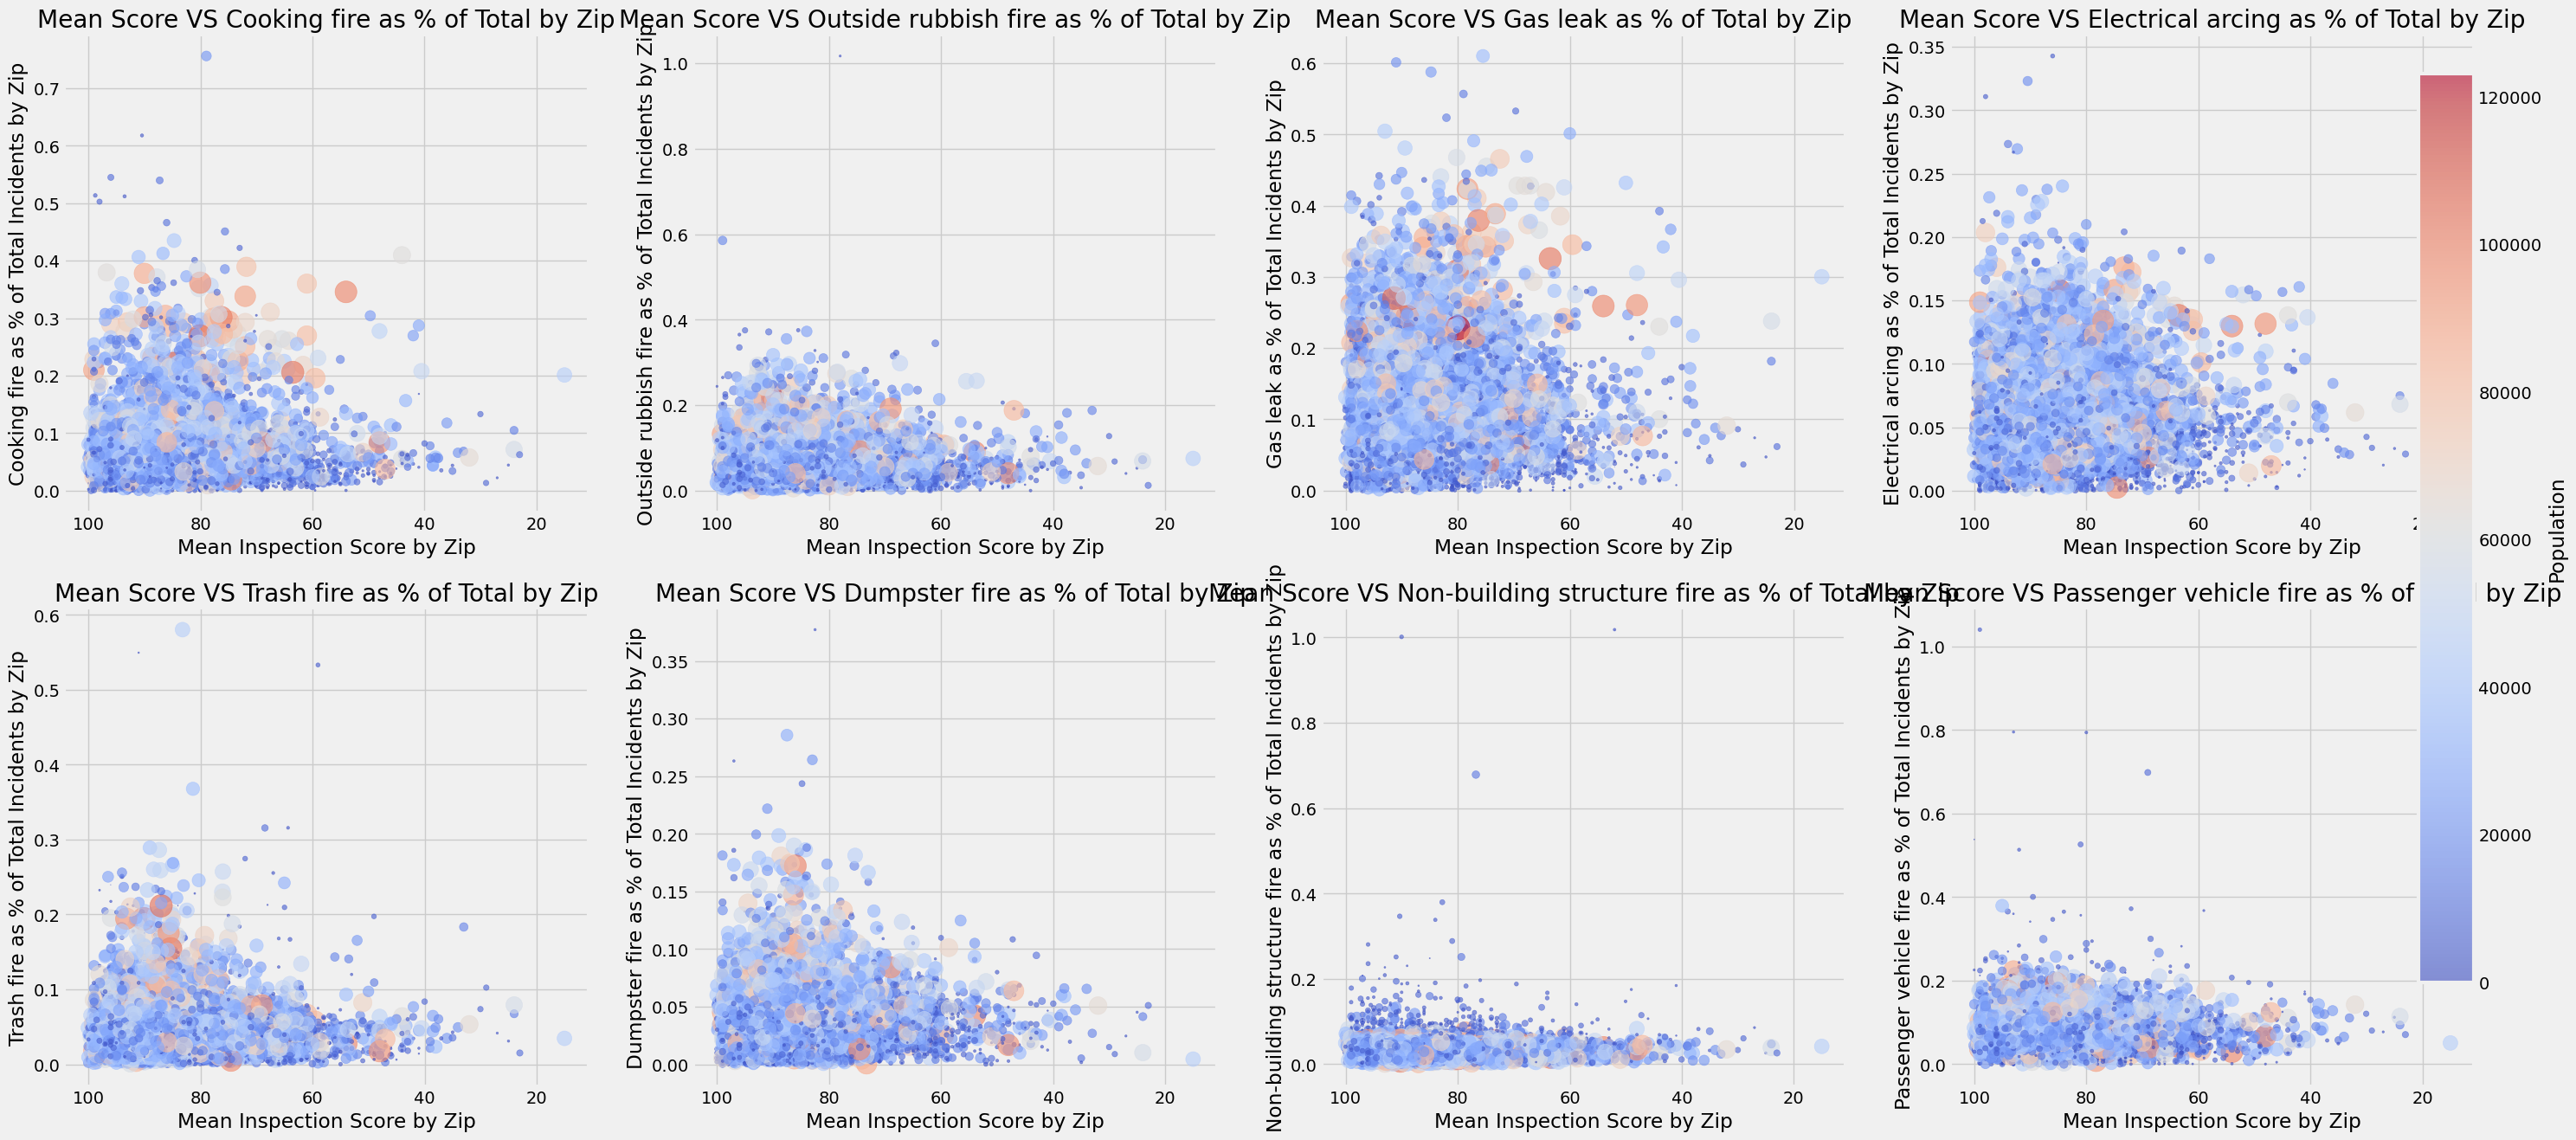

In [300]:
plt.style.use('fivethirtyeight')

incidents = [113, 151, 412, 445, 118, 154, 112, 131]
labels = [
    "Cooking fire",
    "Outside rubbish fire",
    "Gas leak",
    "Electrical arcing",
    "Trash fire",
    "Dumpster fire",
    "Non-building structure fire",
    "Passenger vehicle fire"
    ]

n_rows = 2
n_cols = 4

# Remove rows with NaN values in the 'INSPECTION_SCORE' column
df = type_score_pop.dropna(subset=['INSPECTION_SCORE'])

# Create the subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(32, 15))
axes = axes.flatten()

for idx, inc in enumerate(incidents):
    ax = axes[idx]
    
    # Use a color map based on 'population'
    cmap = plt.cm.get_cmap("coolwarm")
    norm = plt.Normalize(df['population'].min(), df['population'].max())

    # Add jitter to the x and y coordinates
    jitter_x = 0.05 * np.random.rand(len(df))
    jitter_y = 0.05 * np.random.rand(len(df))

    scatter = ax.scatter(df['INSPECTION_SCORE'] + jitter_x, df[str(inc)] + jitter_y,
                s=df['population'] / 300, c=df['population'], cmap=cmap, norm=norm, alpha=0.6)

    ax.set_xlabel('Mean Inspection Score by Zip')
    ax.set_ylabel(f'{labels[idx]} as % of Total Incidents by Zip')
    ax.set_title(f'Mean Score VS {labels[idx]} as % of Total by Zip')

    # Flip the x-axis
    ax.set_xlim(ax.get_xlim()[::-1])

# Add a colorbar
cbar_ax = fig.add_axes([0.93, 0.15, 0.02, 0.7])
cbar = fig.colorbar(scatter, cax=cbar_ax)
cbar.set_label('Population')

# Show the plot
plt.show()